In [44]:
# Imported dependencies. 'fivethirtyeight' replicates the visualization styles from FiveThirtyEight.com 
# Can remove fivethirtyeight as default style by plt.rcdefaults(). 

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [45]:
# These are more dependencies for the graphing and working tables.

import numpy as np
import pandas as pd

In [46]:
# Setting up datetime to refer to module as dt.xxxx

import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [47]:
# Python SQL toolkit and Object Relational Mapper
    # This sets up the interaction with the database, with sessions that can be opened and closed.
    # SQLAlchemy is a Python sql toolkit and ORM. Not very fast or ideal for production.
    
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [48]:
# This function of creating the engine produces an engine object based on a local resource. 
# Sqlite is read/writing ordinary disk file.

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [49]:
# reflect an existing database into a new model
    #Tables will require a primary key, added soon after in this run
Base = automap_base()
# reflect the tables
    #This reflects the schema and produces mappings.
Base.prepare(engine, reflect=True)

In [50]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [51]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [52]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis
   # 1.   Precipitation Analysis

C:\Users\la_le\Anaconda3\envs\ut_data\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


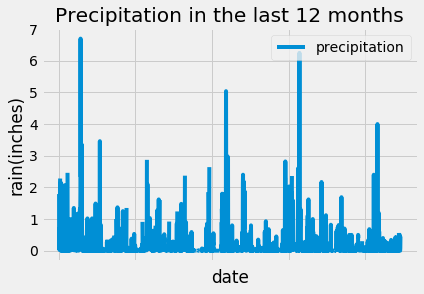

In [61]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 
    # So descending order is in the query. Selecting only date and prcp values: 
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
    # This dataset ends in 2017 so lacks more recent data which would be interesting 
    # with the ongoing volcanic activity that started in 2018.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
    # The sort is ascending, automatically.
df = df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
    # Assumed rain in inches for the American state of Hawaii
    # saved figure to images folder as precipitation.png
    # df.plot(x_compat=True)
df.plot(title="Precipitation in the last 12 months")
plt.legend(loc='upper right')
plt.xlabel("date")
plt.ylabel("rain(inches)")

plt.savefig("Images/precipitation.png")
plt.show()


In [54]:
# Use Pandas to calculate the summary statistics for the precipitation data
    #The results shown are for the time frame of the 12 months in the query. Sorry, no units were provided in the data.
    
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# 2. Station Analysis

In [55]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Measurement.station).distinct().count()
print(f"Total Number of Stations :{total_stations}")

Total Number of Stations :9


In [56]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,
                                func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"Most Active Stations")
active_stations

Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [62]:
#Which station has the highest number of weather observations?
most_active_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()
busiest = most_active_station[0][0]    
print("The Most Active Station Was",busiest,"With",most_active_station[0][1],"Weather Observations.")
print()

The Most Active Station Was USC00519281 With 2772 Weather Observations.



In [74]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# Which station has the highest number of temperature observations?
most_active_station=active_stations[0][0]
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), 
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
print(f"The Most Active Station Recorded Temperatures:")
    # Print busiest's temperatures
print(f"Low: {most_active_temps[0][0]} High: {most_active_temps[0][1]} Average: {round(most_active_temps[0][2], 1)}")

The Most Active Station Recorded Temperatures:
Low: 54.0 High: 85.0 Average: 71.7


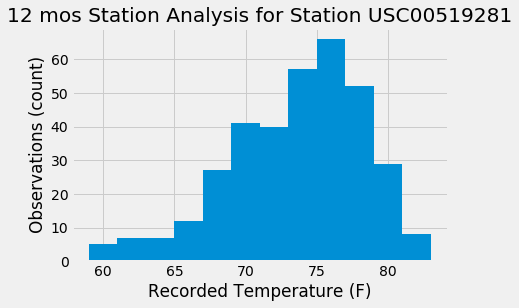

In [82]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
    #Plot the results as a histogram with `bins=12`.
# Which station has the highest number of temperature observations?
most_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_temps_station= most_temps_station[0]

#temperature_observations = session.query( Measurement.tobs).filter(Measurement.date >= prev_year).filter(Measurement.station == most_temps_station).all()
#temperature_observations = pd.DataFrame(temperature_observations, columns=['temperature'])

temperature_observations = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest).\
    filter(Measurement.date > prev_year).\
    order_by(Measurement.date).all()

        #Saved hisogram plot as Images/station-histogram.png
temp_df=pd.DataFrame(temperature_observations)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature (F)")
plt.ylabel("Observations (count)")
plt.title("12 mos Station Analysis for Station " + busiest)
plt.savefig('Images/station-histogram.png')
plt.show()

In [84]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [86]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2012-08-31','2012-09-04')
trip

[(67.0, 75.38235294117646, 82.0)]

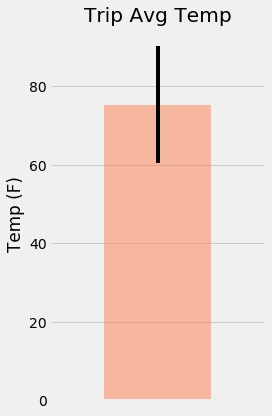

In [90]:
# Plot the results from previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
calc_temp_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])
calc_temp_df.plot.bar(y='tavg', yerr=(calc_temp_df['tmax'] - calc_temp_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
    #Saved image to Images/Temperature.png
plt.savefig('Images/Temperature.png')
plt.show()

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [88]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


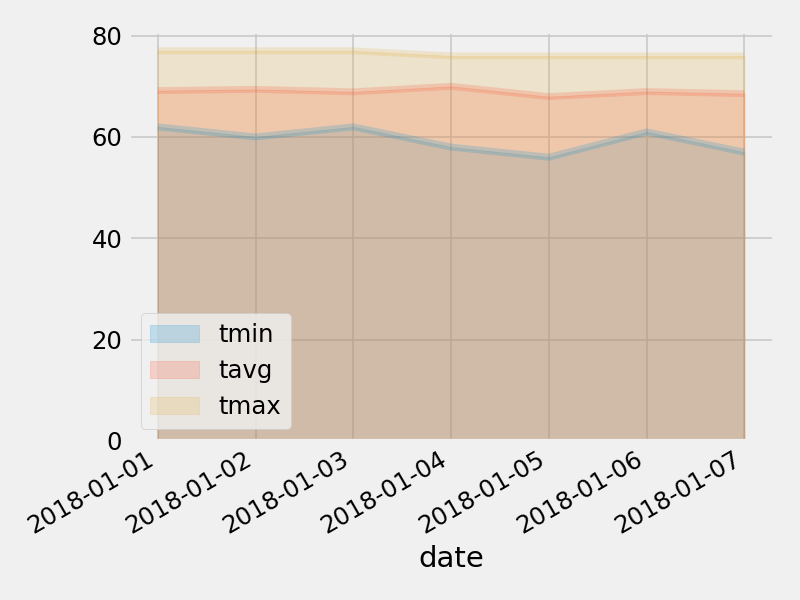

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
